## IMPORTING AND DISPLAYING DATA

In [1]:
import numpy as np
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print (X_train.shape)
print (X_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


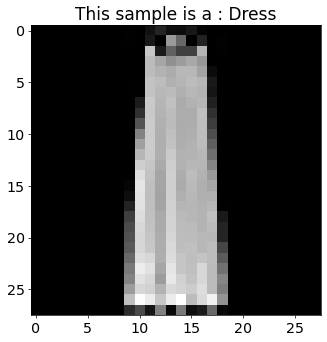

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def display_sample(num):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandals", 
          "Shirt", "Sneaker", "Bag", "Ankle boot"]
    label = labels[y_train[num]]
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(9, 6), dpi=64)
    plt.title(f'This sample is a : {label}')
    plt.imshow(X_train[num], cmap='gray')
    plt.show()
        
display_sample(2137)

## PREPROCESSING

In [3]:
#reshaping data
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1]*X_test.shape[2]])

In [4]:
#normalizing data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
#checking null values
print(np.isnan(X_train).any())
print(np.isnan(X_test).any())

False
False


In [6]:
#data shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [7]:
#performing pca dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

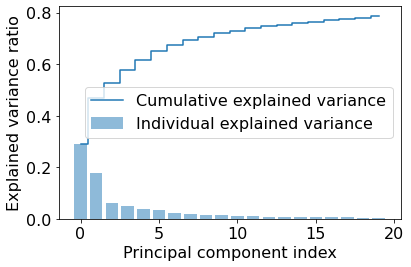

In [8]:
#plotting explained variance of pca components
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

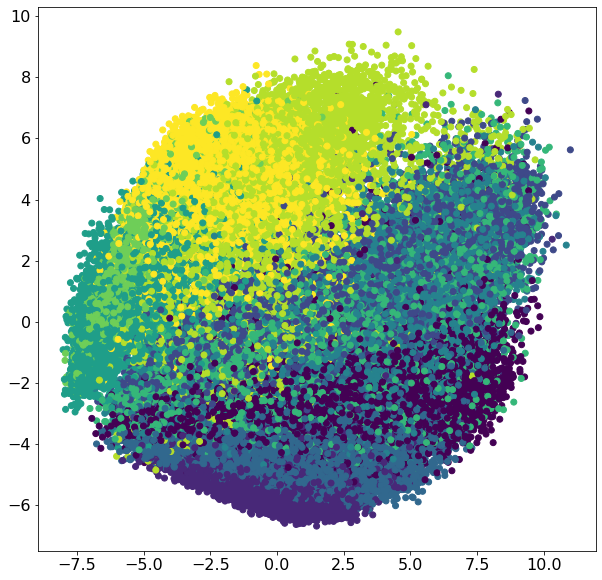

In [11]:
#scatter plot of the reduced data
plt.figure(figsize=(10,10))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
plt.show()

## CLASSIFICATION - PCA


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

RANDOM STATE

In [13]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              "penalty":["l1","l2"]}

grid = GridSearchCV(LogisticRegression(), param_grid)

# fitting the model for grid search
grid.fit(X_train_pca, y_train)
print(grid.best_params_)

{'C': 1000, 'penalty': 'l2'}


In [15]:
lr = LogisticRegression(C=1000, penalty='l2', random_state=42)
lr.fit(X_train_pca, y_train)

lr_pca_mean_score = cross_val_score(lr, X_train_pca, y_train, cv=3, scoring='f1_weighted').mean()
lr_pca_std_score = cross_val_score(lr, X_train_pca, y_train, cv=3, scoring='f1_weighted').std()
print(f'f1 mean score: {lr_pca_mean_score}')
print(f'f1 std score: {lr_pca_std_score}')

f1 mean score: 0.8077126538198603
f1 std score: 0.0007980229449366654


In [17]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': ['auto'],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid)

# fitting the model for grid search
grid.fit(X_train_pca, y_train)
print(grid.best_params_)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [19]:
svc = SVC(C=10, gamma='auto', kernel='rbf', random_state=42)
svc.fit(X_train_pca, y_train)

svc_pca_mean_score = cross_val_score(svc, X_train_pca, y_train, cv=3, scoring='f1_weighted').mean()
svc_pca_std_score = cross_val_score(svc, X_train_pca, y_train, cv=3, scoring='f1_weighted').std()
print(f'f1 mean score: {svc_pca_mean_score}')
print(f'f1 std score: {svc_pca_std_score}')

f1 mean score: 0.8775549212023074
f1 std score: 0.002283346586814286


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

In [21]:
#building MLP
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(20,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


In [22]:
#f1score implementation for Keras
#taken from old keras source code
import keras.backend as K
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
#compiling the model

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=[get_f1])

In [24]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [25]:
history = model.fit(X_train_pca, Y_train,
                    batch_size=300,
                    epochs=25,
                    verbose=2,
                    validation_data=(X_test_pca, Y_test))

Epoch 1/25
200/200 - 5s - loss: 0.5570 - get_f1: 0.7887 - val_loss: 0.4506 - val_get_f1: 0.8316 - 5s/epoch - 26ms/step
Epoch 2/25
200/200 - 4s - loss: 0.4307 - get_f1: 0.8415 - val_loss: 0.4235 - val_get_f1: 0.8444 - 4s/epoch - 19ms/step
Epoch 3/25
200/200 - 4s - loss: 0.3973 - get_f1: 0.8532 - val_loss: 0.3991 - val_get_f1: 0.8546 - 4s/epoch - 19ms/step
Epoch 4/25
200/200 - 4s - loss: 0.3781 - get_f1: 0.8606 - val_loss: 0.3976 - val_get_f1: 0.8536 - 4s/epoch - 18ms/step
Epoch 5/25
200/200 - 4s - loss: 0.3630 - get_f1: 0.8657 - val_loss: 0.3840 - val_get_f1: 0.8621 - 4s/epoch - 19ms/step
Epoch 6/25
200/200 - 4s - loss: 0.3530 - get_f1: 0.8697 - val_loss: 0.3796 - val_get_f1: 0.8638 - 4s/epoch - 19ms/step
Epoch 7/25
200/200 - 4s - loss: 0.3435 - get_f1: 0.8728 - val_loss: 0.3750 - val_get_f1: 0.8653 - 4s/epoch - 18ms/step
Epoch 8/25
200/200 - 4s - loss: 0.3364 - get_f1: 0.8764 - val_loss: 0.3759 - val_get_f1: 0.8639 - 4s/epoch - 19ms/step
Epoch 9/25
200/200 - 4s - loss: 0.3297 - get_f1:

## Classification without reduced dimensionality

In [26]:
lr = LogisticRegression(C=1000, penalty='l2', random_state=42)
lr.fit(X_train, y_train)

lr_mean_score = cross_val_score(lr, X_train, y_train, cv=3, scoring='f1_weighted').mean()
lr_std_score = cross_val_score(lr, X_train, y_train, cv=3, scoring='f1_weighted').std()
print(f'f1 mean score: {lr_mean_score}')
print(f'f1 std score: {lr_std_score}')

f1 mean score: 0.8544344069365645
f1 std score: 0.0026869685924561944


In [28]:
#MLP
#building MLP
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


In [29]:
#compiling the model

model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=[get_f1])

In [30]:
history_1 = model.fit(X_train, Y_train,
                    batch_size=250,
                    epochs=25,
                    verbose=2,
                    validation_data=(X_test, Y_test))

Epoch 1/25
240/240 - 7s - loss: 0.6076 - get_f1: 0.7671 - val_loss: 0.4588 - val_get_f1: 0.8331 - 7s/epoch - 30ms/step
Epoch 2/25
240/240 - 6s - loss: 0.4149 - get_f1: 0.8446 - val_loss: 0.4346 - val_get_f1: 0.8295 - 6s/epoch - 26ms/step
Epoch 3/25
240/240 - 6s - loss: 0.3684 - get_f1: 0.8634 - val_loss: 0.3813 - val_get_f1: 0.8626 - 6s/epoch - 25ms/step
Epoch 4/25
240/240 - 7s - loss: 0.3424 - get_f1: 0.8727 - val_loss: 0.3585 - val_get_f1: 0.8655 - 7s/epoch - 30ms/step
Epoch 5/25
240/240 - 6s - loss: 0.3230 - get_f1: 0.8793 - val_loss: 0.3877 - val_get_f1: 0.8593 - 6s/epoch - 26ms/step
Epoch 6/25
240/240 - 6s - loss: 0.3077 - get_f1: 0.8870 - val_loss: 0.3955 - val_get_f1: 0.8654 - 6s/epoch - 26ms/step
Epoch 7/25
240/240 - 6s - loss: 0.2974 - get_f1: 0.8896 - val_loss: 0.3556 - val_get_f1: 0.8707 - 6s/epoch - 26ms/step
Epoch 8/25
240/240 - 6s - loss: 0.2874 - get_f1: 0.8935 - val_loss: 0.3322 - val_get_f1: 0.8809 - 6s/epoch - 26ms/step
Epoch 9/25
240/240 - 6s - loss: 0.2786 - get_f1:

## SUMMARY

RESULTS FOR PCA


In [31]:
print(f'Logistic Regression f1 mean score: {lr_pca_mean_score}')
print(f'Logistic Regression f1 std score: {lr_pca_std_score}')

print(f'SVC f1 mean score: {svc_pca_mean_score}')
print(f'SVC f1 std score: {svc_pca_std_score}')

Logistic Regression f1 mean score: 0.8077126538198603
Logistic Regression f1 std score: 0.0007980229449366654
SVC f1 mean score: 0.8775549212023074
SVC f1 std score: 0.002283346586814286


Multilayer perceptron

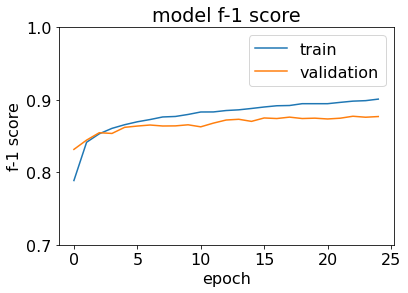

In [37]:
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model f-1 score')
plt.ylabel('f-1 score')
plt.ylim((0.7, 1))
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [33]:
max_f1 = np.max(history.history['val_get_f1'])
avg_f1 = sum(history.history['val_get_f1'])/25
print(f'Max f-1 score value: {max_f1}')
print(f'Avg f-1 score value: {avg_f1}')

Max f-1 score value: 0.8773593306541443
Avg f-1 score value: 0.8667283034324647


RESULTS WITHOUT PCA

In [35]:
print(f'Logistic Regression f1 mean score: {lr_mean_score}')
print(f'Logistic Regression f1 std score: {lr_std_score}')

Logistic Regression f1 mean score: 0.8544344069365645
Logistic Regression f1 std score: 0.0026869685924561944


Multilayer perceptron

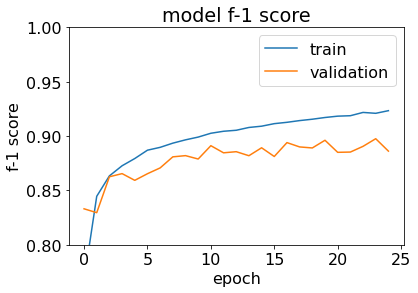

In [39]:
plt.plot(history_1.history['get_f1'])
plt.plot(history_1.history['val_get_f1'])
plt.title('model f-1 score')
plt.ylabel('f-1 score')
plt.ylim((0.8, 1))
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [38]:
max_f1 = max(history_1.history['val_get_f1'])
avg_f1 = sum(history_1.history['val_get_f1'])/25
print(f'Max f-1 score value: {max_f1}')
print(f'Avg f-1 score value: {avg_f1}')

Max f-1 score value: 0.8975762128829956
Avg f-1 score value: 0.8782257318496705
